In [1]:
import os
import requests
from dotenv import load_dotenv

from langchain_openai import AzureChatOpenAI

# from openai import AzureOpenAI
# from langchain.chat_models import init_chat_model

from langchain.tools import tool
from langchain.agents import create_agent
from langchain.agents.middleware import HumanInTheLoopMiddleware

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Command

pwd = %pwd
env_path = os.path.join(pwd,'.env')

load_dotenv(env_path)


/mnt/custom-file-systems/efs/fs-0713103aada1ad94d_fsap-03d52ef0d5b91b6d3/LLM-World/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
os.getenv('AZURE_OPENAI_BASEURL')

'https://bms-openai-proxy-eus-prod.azu.bms.com/openai-urls.json'

In [3]:
# os.environ

In [4]:
# response = requests.get(os.getenv('AZURE_OPENAI_BASEURL'))
# response.json()['nonprod'].keys()
# response.json()['nonprod']['dall-e-3']


In [5]:
response = requests.get(os.getenv('AZURE_OPENAI_BASEURL'))

model_endpoint = {}
for obj_name in response.json()['nonprod']:
    model_endpoint[response.json()['nonprod'][obj_name][0]['deployment_name']]=response.json()['nonprod'][obj_name][0]['endpoint']

model_endpoint.keys()

dict_keys(['dall-e-3', 'gpt-4.1', 'gpt-4.1-mini', 'gpt-4.1-nano', 'gpt-4o-audio-preview', 'gpt-4o-global', 'gpt-4o-mini-global', 'gpt-4o-regional', 'gpt-5', 'gpt-5-chat', 'gpt-5-mini', 'gpt-5-nano', 'gpt-5.1', 'gpt-5.1-chat', 'gpt-audio', 'gpt-audio-mini', 'gpt-image-1', 'gpt-image-1-mini', 'model-router', 'o1', 'o3', 'o3-mini', 'o4-mini', 'text-embedding-3-large', 'text-embedding-3-small', 'text-embedding-ada-002'])

In [6]:
model_endpoint['gpt-4.1']

'https://bms-openai-services-australiaeast-1-nonprod.azu.bms.com'

In [7]:
modle_id = 'gpt-4.1'
model = AzureChatOpenAI(
    deployment_name=modle_id,  
    openai_api_version="2025-03-01-preview",
    # openai_api_version="2024-12-01-preview",
    azure_endpoint=model_endpoint['gpt-4.1'],
    api_key=os.getenv('AZURE_OPENAI_KEY'),
    temperature=0)

In [8]:
model

AzureChatOpenAI(profile={'max_input_tokens': 1047576, 'max_output_tokens': 32768, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x7fe003d304d0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7fe0037c2550>, root_client=<openai.lib.azure.AzureOpenAI object at 0x7fe003ede290>, root_async_client=<openai.lib.azure.AsyncAzureOpenAI object at 0x7fe003e87850>, temperature=0.0, model_kwargs={}, stream_usage=True, disabled_params={'parallel_tool_calls': None}, azure_endpoint='https://bms-openai-services-australiaeast-1-nonprod.azu.bms.com', deployment_name='gpt-4.1', openai_api_version='2025-

In [9]:
@tool
def create_calendar_event(
    title:str,
    start_time:str,
    end_time:str,
    atendees:list[str],
    location:str=""
) -> str:
    """create calendar event"""
    return f"Created event: {title} from {start_time} to {end_time} with {len(atendees)} atendees."

@tool
def send_email(
    to:list[str],
    subject:str,
    body:str,
    cc:list[str]
) -> str:
    """send an email via api"""
    return f"Email sent to {','.join(to)} - Subject: {subject}"


@tool
def get_available_time_slots(
    atendees:list[str],
    date:str,
    duration_minutes:int,
)-> list[str]:
    """Check calendar availability for a given atendee on a specific date"""
    return ["09:00","14:00","16:00"]

### Subagent

In [10]:
CALENDAR_AGENT_PROMPT = (
    "You are a calendar scheduling assistant. "
    "Parse natural language scheduling requests (eg, 'next Tuesday at 2pm') "
    "into proper ISO datetime formats. "
    "Use get_available_time_slots to check availability when needed. "
    "Use create_calendar_event to schedule events. "
    "Always confirm what was scheduled in your final response. "
)



calendar_agent = create_agent(
    model,
    tools=[create_calendar_event, get_available_time_slots],
    system_prompt=CALENDAR_AGENT_PROMPT
)

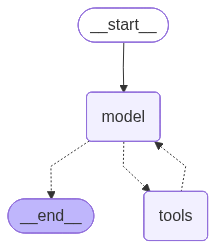

In [11]:
calendar_agent

In [12]:
## test agent

query = "Schedule a team meeting next Tuesday at 2pm for 1 hour"

## surface real-time response from agent
for step in calendar_agent.stream(
    {"messages":[{"role":"user","content":query}]}, 
    #stream_mode="updates" #emits an event after every step
):
    print(step.values())

dict_values([{'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 178, 'total_tokens': 209, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_f99638a8d7', 'id': 'chatcmpl-CjHRrcic0jQNutfjdZGwHlM182QgU', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='lc_run--3da14e92-88c7-4bb1-aeb4-6e759c0e53c9-0', tool_calls=[{'name': 'get_available_ti

In [13]:
## test agent

query = "Schedule a team meeting next Tuesday at 2pm for 1 hour"

## surface real-time response from agent (progress, intermediate steps, partial responses as they are generated)
for step in calendar_agent.stream(
    {"messages":[{"role":"user","content":query}]}, 
    #stream_mode="updates" #emits an event after every step
):
    # print(step.values())
    for update in step.values():
        for message in update.get("messages", []):
            message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  get_available_time_slots (call_gvA0BDp9bzonjqkiaKa1bXny)
 Call ID: call_gvA0BDp9bzonjqkiaKa1bXny
  Args:
    atendees: []
    date: 2024-06-18
    duration_minutes: 60
================================= Tool Message =================================
Name: get_available_time_slots

["09:00", "14:00", "16:00"]
================================== Ai Message ==================================
Tool Calls:
  create_calendar_event (call_0Pe959gyy7i9a5zaiWLFVHlm)
 Call ID: call_0Pe959gyy7i9a5zaiWLFVHlm
  Args:
    title: Team Meeting
    start_time: 2024-06-18T14:00:00
    end_time: 2024-06-18T15:00:00
    atendees: []
================================= Tool Message =================================
Name: create_calendar_event

Created event: Team Meeting from 2024-06-18T14:00:00 to 2024-06-18T15:00:00 with 0 atendees.
================================== Ai Message ==================================

The

In [14]:
for chunk in calendar_agent.stream(
    {"messages":[{"role":"user","content":query}]}, 
    stream_mode="updates" #emits an event after every step
):
    print(chunk.items())

dict_items([('model', {'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 178, 'total_tokens': 209, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_f99638a8d7', 'id': 'chatcmpl-CjHRyyugcZ1H8oARMc516iezhQujm', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='lc_run--1450540f-039d-430a-94df-3c60adb6ce5f-0', tool_calls=[{'name': 'get_ava

In [15]:
for chunk in calendar_agent.stream(
    {"messages":[{"role":"user","content":query}]}, 
    stream_mode="updates" #emits an event after every step
):

    for step, data in chunk.items():
        print(f"steps: {step}")
        print(f"content: {data['messages'][-1].content_blocks}")

steps: model
content: [{'type': 'tool_call', 'name': 'get_available_time_slots', 'args': {'atendees': [], 'date': '2024-06-18', 'duration_minutes': 60}, 'id': 'call_aanzLg7sy6HFwXvqQC3ls3ik'}]
steps: tools
content: [{'type': 'text', 'text': '["09:00", "14:00", "16:00"]'}]
steps: model
content: [{'type': 'tool_call', 'name': 'create_calendar_event', 'args': {'title': 'Team Meeting', 'start_time': '2024-06-18T14:00:00', 'end_time': '2024-06-18T15:00:00', 'atendees': []}, 'id': 'call_qjmXQJXjdxanLqvDSBHy8NN9'}]
steps: tools
content: [{'type': 'text', 'text': 'Created event: Team Meeting from 2024-06-18T14:00:00 to 2024-06-18T15:00:00 with 0 atendees.'}]
steps: model
content: [{'type': 'text', 'text': 'The team meeting has been scheduled for next Tuesday, June 18th, from 2:00 PM to 3:00 PM. If you would like to add attendees or a location, please let me know!'}]


In [16]:
for chunk in calendar_agent.stream(
    {"messages":[{"role":"user","content":query}]}, 
    stream_mode="updates" #emits an event after every step
):

    for step, data in chunk.items():
        print(f"steps: {step}")
        print(f"content: {data['messages'][-1].content}")

steps: model
content: Could you please provide the list of attendees for the team meeting? This will help me check their availability and schedule the meeting accordingly.


In [17]:
## final answer w/o realtime feedback
response = calendar_agent.invoke({"messages":[{"role":"user","content":query}]})
response

{'messages': [HumanMessage(content='Schedule a team meeting next Tuesday at 2pm for 1 hour', additional_kwargs={}, response_metadata={}, id='fbba54fd-d974-43ab-912c-01b803e43f44'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 178, 'total_tokens': 209, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_f99638a8d7', 'id': 'chatcmpl-CjHS7mQGm3MUKMPsDtKutm4xYRL6u', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason'

In [18]:
# response['messages'][-1].content
response['messages'][-1].text

'The team meeting is scheduled for next Tuesday, June 18th, from 2:00 PM to 3:00 PM. If you would like to add attendees or a location, please let me know!'

In [19]:
## eamil agent

EMAIL_AGENT_PROMPT = (
    "You are an email assitant. "
    "Compose professional emails based on natural language requests. "
    "Extract recipient information and craft apropriate subject lines and body text. "
    "Use send_email to send the message. "
    "Always confirm what was sent in your final response. "
)

email_agent = create_agent(
    model,
    tools=[send_email],
    system_prompt=EMAIL_AGENT_PROMPT
)

In [20]:
query = "send the design team a reminder about reviewing the new mock"

for step in email_agent.stream({"messages": [{"role":"user", "content":query}]}):
    for update in step.values():
        for message in update.get("messages",[]):
            message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  send_email (call_7PQXNMYLV5AZmtWD6z926i6n)
 Call ID: call_7PQXNMYLV5AZmtWD6z926i6n
  Args:
    to: ['design-team@example.com']
    subject: Reminder: Please Review the New Mock
    body: Hello Design Team,

This is a friendly reminder to review the new mock that was recently shared. Your feedback is important to ensure we stay on track with our project timeline.

Please take a moment to review the mock and share your comments or suggestions at your earliest convenience.

Thank you!

Best regards,
[Your Name]
    cc: []
================================= Tool Message =================================
Name: send_email

Email sent to design-team@example.com - Subject: Reminder: Please Review the New Mock
================================== Ai Message ==================================

I have sent a reminder email to the design team asking them to review the new mock. The subject of the email was 

In [21]:
response = email_agent.invoke({"messages":[{"role":"user","content":query}]})
response

{'messages': [HumanMessage(content='send the design team a reminder about reviewing the new mock', additional_kwargs={}, response_metadata={}, id='c6f7dfd7-e650-45e6-9e63-9b66de37fdc6'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 107, 'prompt_tokens': 115, 'total_tokens': 222, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_f99638a8d7', 'id': 'chatcmpl-CjHSD3djzTCXpxHGBdwBwbQaRqUY5', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_

In [22]:
response['messages'][-1].content
# response['messages'][-1].text

'I have sent a reminder email to the design team asking them to review the new mock. The subject of the email was "Reminder: Please Review the New Mock." If you need any further follow-up or adjustments, please let me know!'

#### Wrap subagent as a tool for supervisor to call

In [23]:
@tool
def schedule_event(request: str) -> str:
    """Schedule calendar events using natural language.

    Use this when the user wants to create, modify or check calendar appointments.
    Handles date/time parsing, availability checking, and event creation.


    Input: Natural language scheduling request (e.g., 'meeting with design team next Tuesday at 2pm')
    """
    result = calendar_agent.invoke({
        "messages":[{"role":"user", "content":request}]
        })
    return result['messages'][-1].content


@tool
def manage_email(request: str) -> str:
    """ Send emails using natural language.

    Use this when the user wants to send notifications, reminders, or any
    communication. Handles recipient extraction, subject generation, and email composisiton.

    Input: Natural language email request (e.g., 'send time reminder about the meeting' )
    """
    result = email_agent.invoke({
        "messages":[{"role":"user", "content":request}]
    })
    return result['messages'][-1].text
    

##### Supervisor Agent

In [27]:
SUPERVISOR_PROMPT = (
    "You are a helpful personal assistant. "
    "You can schedule calendar events and send emails. "
    "Break down uer requests into appropriate tool calls and coorddinate the results. "
    "When a request involves multiple actions, use multiple tools in sequence. "
)

supervisor_agent = create_agent(
    model,
    tools=[schedule_event, manage_email],
    system_prompt=SUPERVISOR_PROMPT,
)

In [28]:
query = "Schedule a team standup for tomorrow at 9am"

for steps in supervisor_agent.stream(
    {"messages":[{"role":"user","content":query}]}):
    for update in steps.values():
        for messages in update.get("messages",[]):
            messages.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  schedule_event (call_NrL8aX9yyr8bS7f6J8hJDmWJ)
 Call ID: call_NrL8aX9yyr8bS7f6J8hJDmWJ
  Args:
    request: Schedule a team standup for tomorrow at 9am
================================= Tool Message =================================
Name: schedule_event

The team standup has been scheduled for tomorrow at 9:00 AM. If you would like to add attendees or specify a location, please let me know!
================================== Ai Message ==================================

The team standup has been scheduled for tomorrow at 9:00 AM. If you need to add attendees or specify a location, just let me know!


In [29]:
query = (
    "Schedule a meetinng with the design team next Tuesday at 2pm for 1 hour, "
    "and sned them an email reminder about reviewing the new mockups."
    )

for steps in supervisor_agent.stream(
    {"messages":[{"role":"user","content":query}]}):
    for update in steps.values():
        for messages in update.get("messages",[]):
            messages.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  schedule_event (call_YplNMsdHxdXn6QI1oNPwyjYB)
 Call ID: call_YplNMsdHxdXn6QI1oNPwyjYB
  Args:
    request: Schedule a meeting with the design team next Tuesday at 2pm for 1 hour
  manage_email (call_6AoYV0IZTGOET3CMWoBh1jXq)
 Call ID: call_6AoYV0IZTGOET3CMWoBh1jXq
  Args:
    request: Send an email reminder to the design team about reviewing the new mockups before the meeting next Tuesday at 2pm
================================= Tool Message =================================
Name: manage_email

I have sent an email reminder to the design team, asking them to review the new mockups before the meeting next Tuesday at 2pm. If you need any further follow-up or adjustments, please let me know!
================================= Tool Message =================================
Name: schedule_event

Your meeting with the design team is scheduled for next Tuesday, June 18th, from 2:00 PM to 3:00 PM. Le

#### Human-in-the-loop review

In [30]:
## Human-in-the-loop review for subagents
### configure create_calendar_event and send_email tools to interrupt permitting all response types (approve, edit, reject)
### checkpointer at the top-level agent is required to pause the resume execution

In [31]:
calendar_agent = create_agent(
    model,
    tools=[create_calendar_event, get_available_time_slots],
    system_prompt=CALENDAR_AGENT_PROMPT,
    middleware=[
        HumanInTheLoopMiddleware(
            interrupt_on={"create_calendar_event":True},
            description_prefix="Calendar event pending approval"
        )
    ]
)

In [32]:
email_agent = create_agent(
    model,
    tools=[send_email],
    system_prompt=EMAIL_AGENT_PROMPT,
    middleware=[
        HumanInTheLoopMiddleware(
            interrupt_on={"send_email":True},
            description_prefix="Outbound email pending approval"
        )
    ]
)

In [33]:
supervisor_agent = create_agent(
    model,
    tools=[schedule_event, manage_email],
    system_prompt=SUPERVISOR_PROMPT,
    checkpointer=InMemorySaver()
)

In [34]:
query = (
    "Schedule a meetinng with the design team next Tuesday at 2pm for 1 hour, "
    "and sned them an email reminder about reviewing the new mockups."
    )

config = {"configurable":{"thread_id":"6"}}

interrupts = []

for steps in supervisor_agent.stream(
    {"messages":[{"role":"user","content":query}]}, config):
    for update in steps.values():
        if isinstance(update,dict):
            for messages in update.get("messages",[]):
                messages.pretty_print()
        else:
            interrupt_ = update[0]
            interrupts.append(interrupt_)
            print(f"\nINTERRUPTED: {interrupt_.id}")

================================== Ai Message ==================================
Tool Calls:
  schedule_event (call_bh1uXttwMDRltRJVxPA9AaIK)
 Call ID: call_bh1uXttwMDRltRJVxPA9AaIK
  Args:
    request: Schedule a meeting with the design team next Tuesday at 2pm for 1 hour
  manage_email (call_XH0bbAgr9uhI6ud2HhEJtLQg)
 Call ID: call_XH0bbAgr9uhI6ud2HhEJtLQg
  Args:
    request: Send an email reminder to the design team about reviewing the new mockups before the meeting next Tuesday at 2pm

INTERRUPTED: 0d28e9caabbd1254847fef4ec51f28c3

INTERRUPTED: 0f06d8d32c80c15190d4674acbd2c289


In [35]:
for interrupt in interrupts:
    print(interrupt)

Interrupt(value={'action_requests': [{'name': 'send_email', 'args': {'to': ['designteam@example.com'], 'subject': "Reminder: Review New Mockups Before Next Tuesday's Meeting", 'body': 'Hello Design Team,\n\nThis is a reminder to please review the new mockups before our meeting next Tuesday at 2pm. Your feedback will be valuable for our discussion and next steps.\n\nThank you!\n\nBest regards,\n[Your Name]', 'cc': []}, 'description': 'Outbound email pending approval\n\nTool: send_email\nArgs: {\'to\': [\'designteam@example.com\'], \'subject\': "Reminder: Review New Mockups Before Next Tuesday\'s Meeting", \'body\': \'Hello Design Team,\\n\\nThis is a reminder to please review the new mockups before our meeting next Tuesday at 2pm. Your feedback will be valuable for our discussion and next steps.\\n\\nThank you!\\n\\nBest regards,\\n[Your Name]\', \'cc\': []}'}], 'review_configs': [{'action_name': 'send_email', 'allowed_decisions': ['approve', 'edit', 'reject']}]}, id='0d28e9caabbd125484

In [36]:
for interrupt in interrupts:
    for request in interrupt.value['action_requests']:
        print(f"INTERRUPTED: {interrupt.id}")
        print(f"{request['description']}\n")
    

INTERRUPTED: 0d28e9caabbd1254847fef4ec51f28c3
Outbound email pending approval

Tool: send_email
Args: {'to': ['designteam@example.com'], 'subject': "Reminder: Review New Mockups Before Next Tuesday's Meeting", 'body': 'Hello Design Team,\n\nThis is a reminder to please review the new mockups before our meeting next Tuesday at 2pm. Your feedback will be valuable for our discussion and next steps.\n\nThank you!\n\nBest regards,\n[Your Name]', 'cc': []}

INTERRUPTED: 0f06d8d32c80c15190d4674acbd2c289
Calendar event pending approval

Tool: create_calendar_event
Args: {'title': 'Meeting with Design Team', 'start_time': '2024-06-18T14:00:00', 'end_time': '2024-06-18T15:00:00', 'atendees': ['design team']}



In [37]:
### Specify decisions for each interrup by reffering to its ID using Command (one or more commands to update the graph's STATE and send messeagess to Nodes.)

resume = {}


for interrup in interrupts:
    if interrup.id=="0d28e9caabbd1254847fef4ec51f28c3":
        edited_action = interrup.value['action_requests'].copy()
        print(edited_action)
        print(edited_action[0]['args']['subject'])
        edited_action[0]['args']['subject'] = " Mockups reminder"
        resume[interrup.id] = {
            "decisions":[{"type":"edit", "edited_action":edited_action}]
        }
        print(resume)
    else:
        resume[interrupt.id]={"decisions":[{"type":"approve"}]}
        print(resume)
    

[{'name': 'send_email', 'args': {'to': ['designteam@example.com'], 'subject': "Reminder: Review New Mockups Before Next Tuesday's Meeting", 'body': 'Hello Design Team,\n\nThis is a reminder to please review the new mockups before our meeting next Tuesday at 2pm. Your feedback will be valuable for our discussion and next steps.\n\nThank you!\n\nBest regards,\n[Your Name]', 'cc': []}, 'description': 'Outbound email pending approval\n\nTool: send_email\nArgs: {\'to\': [\'designteam@example.com\'], \'subject\': "Reminder: Review New Mockups Before Next Tuesday\'s Meeting", \'body\': \'Hello Design Team,\\n\\nThis is a reminder to please review the new mockups before our meeting next Tuesday at 2pm. Your feedback will be valuable for our discussion and next steps.\\n\\nThank you!\\n\\nBest regards,\\n[Your Name]\', \'cc\': []}'}]
Reminder: Review New Mockups Before Next Tuesday's Meeting
{'0d28e9caabbd1254847fef4ec51f28c3': {'decisions': [{'type': 'edit', 'edited_action': [{'name': 'send_em

In [38]:
interrupts = []
for step in supervisor_agent.stream(Command(resume=resume), config):
    for update in step.values():
        if isinstance(update, dict):
            for message in update.get("messages",[]):
                message.pretty_print

        else:
            interrupt = update[0]
            interrupts.append(interrupt)
            print(f"\nINTERrUPTED: {interrupt.id}")

TypeError: list indices must be integers or slices, not str